In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from scipy.optimize import least_squares
from IPython.display import Image
import xlrd
import geopandas as gpd
%matplotlib inline

Load and clean CEDA data

In [2]:
path = 'data/CEDA/'
all_files = glob.glob(os.path.join(path, "ceda*.xls*"))
df_list = []
for infile in all_files[0:]:
    print('\n'+infile)
    nom_cols = pd.Index(['MeasID', 'YEAR', 'CO', 'JUR', 'CNTYNAME', 'DATE', 'PLACE', 'CSD',
       'MEASTYPE', 'LTR', 'BALQUEST', 'Orig_TYPE', 'RECTYPE', 'RECTYPENAME',
       'Orig_TOPIC', 'RECTOPIC', 'RECTOPNAME', 'YES', 'NO', 'TOTAL', 'PERCENT',
       'REQ', 'OUTCOME', 'PASSFAIL', 'Multi_CO', 'Multi_MeasID', 'YES_sum',
       'NO_sum', 'Total_sum', 'Percent_sum', 'Outcome_sum', 'passfail_sum',
       'typerec', 'topicrec', 'OTH'],dtype='object')
    xls = pd.ExcelFile(infile)
    df0 = pd.read_excel(xls, 0)
    df1 = pd.read_excel(xls, 1)
    if 'MeasureID' in df0.columns.values or 'MeasID' in df0.columns.values:
        df_this = df0
    else:
        df_this = df1

    if 'MeasID_First' in df_this.columns.values:
        del df_this['MeasID_First']
        
    if 'OTH' not in df_this.columns.values:
        df_this['OTH'] = np.nan
        
    if 'Orig_TYPE' not in df_this.columns.values:
        df_this['Orig_TYPE'] = np.nan
        
    if 'Orig_TOPIC' not in df_this.columns.values:
        df_this['Orig_TOPIC'] = np.nan
    
    cols = df_this.columns.values
    for idx,col in enumerate(cols):
        if col not in nom_cols.values:
            if col in ['TOPICREC','topcrec']:
                cols[idx] = 'topicrec'
            elif col == 'MeasureID':
                cols[idx] = 'MeasID'
            elif col == 'TYPEREC':
                cols[idx] = 'typerec'
            elif col == 'Passfail_sum':
                cols[idx] = 'passfail_sum'
            elif col == 'RECTOPICNAME':
                cols[idx] = 'RECTOPNAME'
            elif col == 'CO#':
                cols[idx] = 'CO'
            else:
                print(col)
    df_this.columns = cols
        
    for nom_col in nom_cols.values:
        if nom_col not in df_this.columns.values:
            print(nom_col)

    if not df_this.columns.equals(nom_cols):
        print(df_this.columns.difference(nom_cols))
        print(nom_cols.difference(df_this.columns))

    df_this.index = df_this['MeasID']
    del df_this['MeasID']
    df.loc[df['CNTYNAME'] == 'SAN BERNADINO','CNTYNAME'] = 'SAN BERNARDINO' # lol
    df_list.append(df_this)


data/CEDA/ceda-2016-data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/ceda1996data.xls

data/CEDA/ceda1997data.xls

data/CEDA/ceda1998data.xls

data/CEDA/ceda1999data.xls

data/CEDA/ceda2000data.xls

data/CEDA/ceda2001data.xls

data/CEDA/ceda2002data.xls

data/CEDA/ceda2003data.xls

data/CEDA/ceda2004data.xls

data/CEDA/ceda2005data.xls

data/CEDA/ceda2006data.xls

data/CEDA/ceda2007data.xls

data/CEDA/ceda2008data.xls

data/CEDA/ceda2009data.xls

data/CEDA/ceda2010data.xls

data/CEDA/ceda2011data.xlsx

data/CEDA/ceda2012data.xlsx

data/CEDA/ceda2013data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/ceda2015data.xlsx
Index([], dtype='object')
Index([], dtype='object')

data/CEDA/cedadata2014.xlsx
Index([], dtype='object')
Index([], dtype='object')


In [ ]:
df = pd.concat(df_list)
df

In [4]:
df['CNTYNAME'] = df['CNTYNAME'].map(lambda x: x.upper())

Get our bearings-- what are the total number of local measures in each county, in this ~20 year dataset

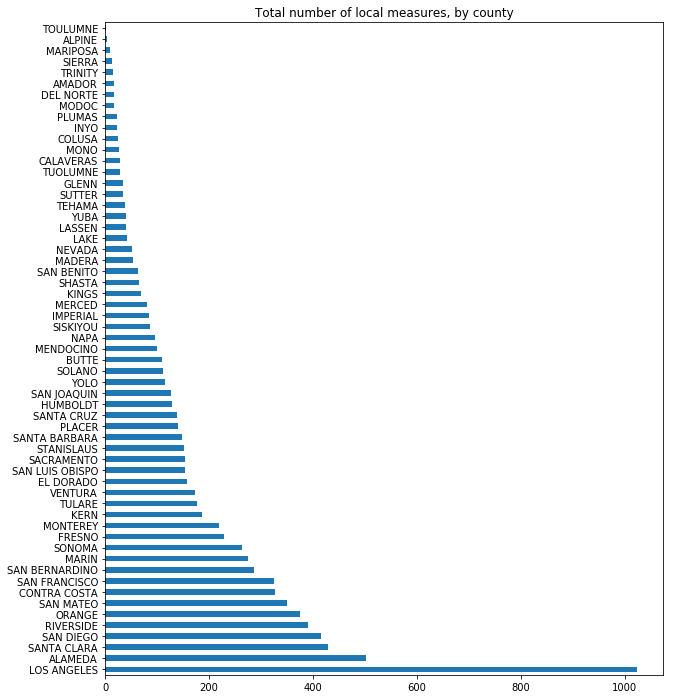

In [30]:
num_measures_tot = df['CNTYNAME'].value_counts()
plt.figure(figsize=(10, 12))
num_measures_tot.plot(kind='barh')
plt.title('Total number of local measures, by county')

Wow, LA really is big. How about just county-level measures? Interestingly, San Francisco county surges into first place.

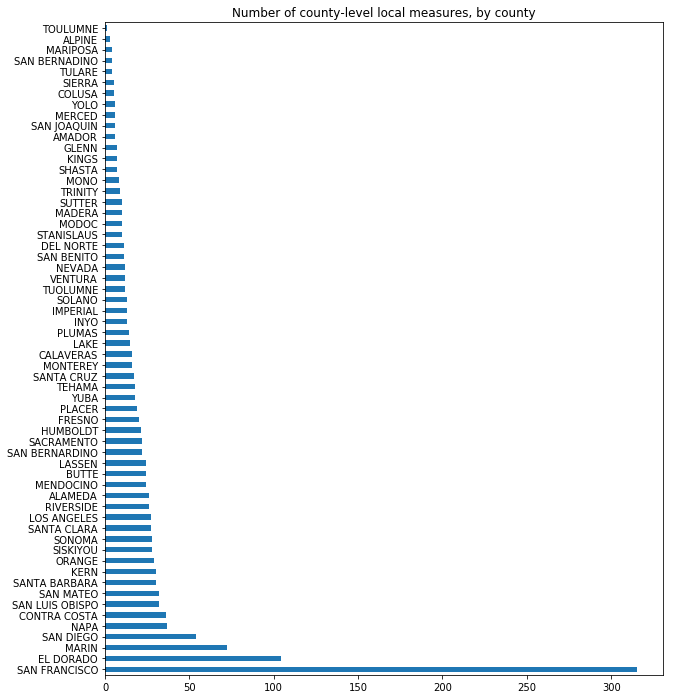

In [6]:
num_measures_county = df.query('JUR == 1')['CNTYNAME'].value_counts()
plt.figure(figsize=(10, 12))
num_measures_county.plot(kind='barh')
plt.title('Number of county-level local measures, by county')

A quick and dirty look at education ballot measures. Of all measures categorized as being education-related, what is the average fraction of 'yes' votes, in each county?

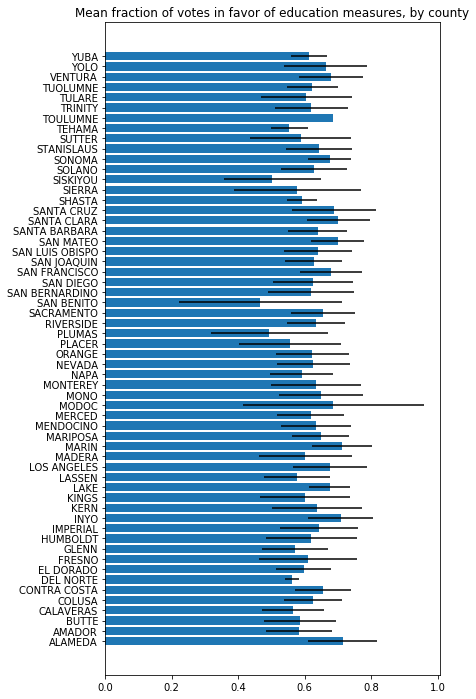

In [31]:
df_ed = df.query('RECTOPIC < 20')
num_ed_by_cnty = df_ed['CNTYNAME'].value_counts().sort_index()
mean_ed_percent_by_cnty = df_ed.groupby('CNTYNAME')['PERCENT'].mean()
std_ed_percent_by_cnty = df_ed.groupby('CNTYNAME')['PERCENT'].std()
ind = np.arange(len(mean_ed_percent_by_cnty))
plt.figure(figsize=(6, 12))
plt.barh(ind,mean_ed_percent_by_cnty.values,xerr=std_ed_percent_by_cnty.values)
plt.yticks(ind,mean_ed_percent_by_cnty.index.values,rotation=0);
plt.title('Mean fraction of votes in favor of education measures, by county')

Let's looks at that data in map form, for kicks.

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


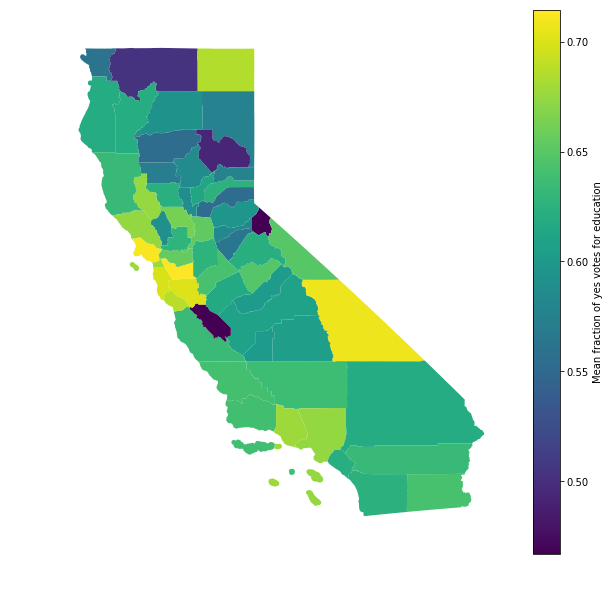

In [32]:
gdf = gpd.read_file('data/shapefiles/CA_Counties/CA_Counties_TIGER2016.shp')
gdf.index = gdf.NAME
gdf.index = gdf.index.str.upper()
gdf.sort_index(inplace=True)
gdf['CHORO_DATA'] = mean_ed_percent_by_cnty
f, ax = plt.subplots(1, figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=gdf['CHORO_DATA'].min(),vmax=gdf['CHORO_DATA'].max())
h_plot = gdf.plot(ax=ax, column='CHORO_DATA',cmap='viridis',vmin = gdf['CHORO_DATA'].min(),vmax=gdf['CHORO_DATA'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []
cbar = f.colorbar(sm)
cbar.ax.set_ylabel('Mean fraction of yes votes for education')
ax.set_axis_off()
plt.axis('equal');

Now here's where things get interesting-- let's try comparing this education-measure popularity rate with voter registration stats, like we did for state-wide measures in the other notebook. Since we're looking at the entire dataset, I'll take the mean of the voter registration data for the x-axis.

In [9]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    return df
df_reg = load_registration_data()

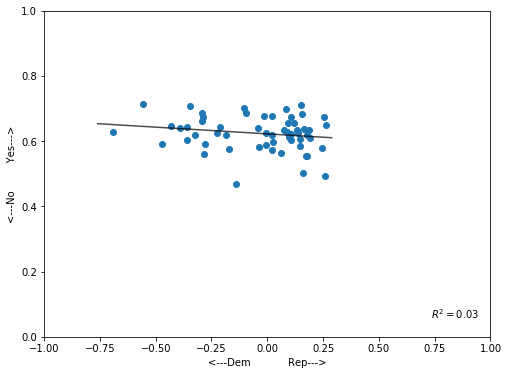

In [37]:
plt.figure(figsize=(8,6))
dem_count = df_reg.loc[idx[:,'Count'],idx[:,'Democratic']]
dem_count.columns = dem_count.columns.droplevel('Category')
dem_count.index = dem_count.index.droplevel('Count_type')
rep_count = df_reg.loc[idx[:,'Count'],idx[:,'Republican']]
rep_count.columns = rep_count.columns.droplevel('Category')
rep_count.index = rep_count.index.droplevel('Count_type')
rd_asym = ((rep_count - dem_count) / (rep_count + dem_count)).drop('State Total')
rd_asym.index = rd_asym.index.str.upper()
plt.scatter(rd_asym.T.mean(),mean_ed_percent_by_cnty)
model_OLS = lm.LinearRegression()
model_OLS.fit(rd_asym.T.mean().values.reshape(-1,1),mean_ed_percent_by_cnty)
X_line = np.linspace(1.1*rd_asym.T.mean().min(),1.1*rd_asym.T.mean().max(),num=20).reshape(-1,1)
y_OLS = model_OLS.predict(X_line)
R2 = model_OLS.score(rd_asym.T.mean().values.reshape(-1,1),mean_ed_percent_by_cnty)
plt.plot(X_line,y_OLS,alpha=0.7,color='k')
plt.xlabel('<---Dem            Rep--->')
plt.ylabel('<---No         Yes--->')
text_str = '$R^2 = ${:.2f}'.format(R2)
plt.xlim([-1,1]);
plt.ylim([0,1]);
plt.text(x=.95,y=.05,s=text_str,ha='right',va='bottom');


This is quite a different story than the statewide measures related to education, which showed a much stronger connection between party affiliation and voting patterns. Perhaps we're seeing that voters value schools in their own districts, but are unwilling to foot the bill for statewide initiatives. This could be an interesting avenue of analysis, especially if I zoom in to the sub-county level.